# NFL clustering

This dataset includes receiving characteristics for all NFL players in 2018. The target vector is their Pro Bowl status for that year, but we don't use it in this case.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from yellowbrick.datasets import load_nfl
# Load nfl dataset dataset
X, y = load_nfl()

# Specify the features to use for clustering
# Only consider the players that had over 20 targets
features = ['Rec', 'Yds', 'TD', 'Fmb', 'Ctch_Rate']
X = X.query('Tgt >= 20')[features]
X

,Rec,Yds,TD,Fmb,Ctch_Rate
0,125,1405,9,2,0.850
1,116,1163,8,1,0.744
2,115,1572,11,2,0.706
3,113,1677,8,2,0.665
4,113,1373,9,1,0.739
...,...,...,...,...,...
266,12,164,3,0,0.480
275,11,80,1,0,0.458
277,11,136,1,0,0.478
284,10,100,1,0,0.417


In [3]:
X.describe()

,Rec,Yds,TD,Fmb,Ctch_Rate
count,260.000000,260.000000,260.000000,260.000000,260.000000
mean,39.807692,459.207692,2.946154,0.857692,0.669150
std,24.760504,330.028037,2.707951,1.124893,0.107095
min,9.000000,72.000000,0.000000,0.000000,0.362000
25%,21.000000,213.000000,1.000000,0.000000,0.600000
50%,32.500000,334.000000,2.000000,1.000000,0.673000
75%,54.000000,622.000000,4.000000,1.000000,0.739000
max,125.000000,1677.000000,15.000000,7.000000,0.958000


## K-means clustering

The first step is to determine how many clusters to use. We can use the elbow method to determine this. Are there any preprocessing steps that we need to do first?

In [4]:
# Implement preprocessing step(s)
from sklearn.preprocessing import StandardScaler

df_scaled = X.copy()

scaler = StandardScaler()
scaler.fit(df_scaled)
df_scaled = pd.DataFrame(scaler.transform(df_scaled), columns=df_scaled.columns)

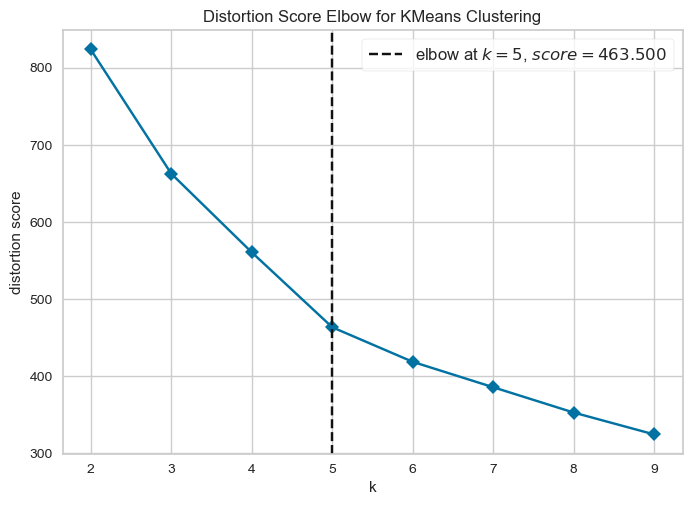

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=54), k=(2, 10),
                 timings=False)

In [5]:
# Use the elbow method to determine the number of clusters to use
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
kelbow_visualizer(KMeans(random_state=54), df_scaled, k=(2,10), 
                  metric='distortion',
                 timings=False)

The next step is to implement the clustering method with the number of clusters determined above. 

In [6]:
kmeans = KMeans(n_clusters=5, random_state=54)
kmeans.fit(df_scaled)

X['clusters'] = kmeans.labels_
X['clusters'] = X['clusters'].astype('category') #makes seaborn use qualitative color palette

In [7]:
X.dtypes

Rec             int64
Yds             int64
TD              int64
Fmb             int64
Ctch_Rate     float64
clusters     category
dtype: object

In [8]:
# Find the cluster center for each cluster (for each feature)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=df_scaled.columns)
centers_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=df_scaled.columns)
centers

,Rec,Yds,TD,Fmb,Ctch_Rate
0,21.400000,260.769231,1.492308,0.476923,0.551246
1,51.367647,634.573529,4.397059,0.735294,0.652000
2,48.526316,475.947368,2.157895,3.684211,0.758263
3,92.291667,1220.708333,8.625000,1.083333,0.685875
4,27.726190,249.440476,1.452381,0.547619,0.749333


In [9]:
centers_scaled

,Rec,Yds,TD,Fmb,Ctch_Rate
0,-0.744863,-0.602437,-0.537916,-0.339147,-1.103050
1,0.467771,0.532391,0.536828,-0.109019,-0.160447
2,0.352797,0.050820,-0.291652,2.517545,0.833699
3,2.123753,2.311832,2.101146,0.200976,0.156471
4,-0.488875,-0.636830,-0.552689,-0.276178,0.750156


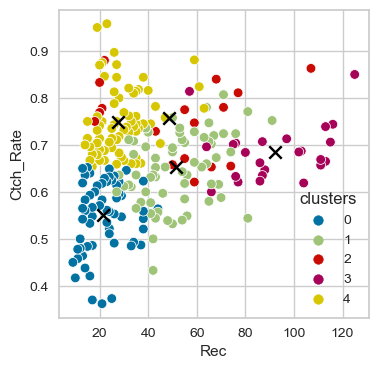

In [11]:
# Plot the clusters (separated by color) with their cluster centers
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.scatterplot(x='Rec', y='Ctch_Rate', hue='clusters', ax=ax, data=X)

centers.plot.scatter(x='Rec', y='Ctch_Rate', ax=ax, marker='x', s=80, color='black');

Counter({4: 84, 1: 68, 0: 65, 3: 24, 2: 19})


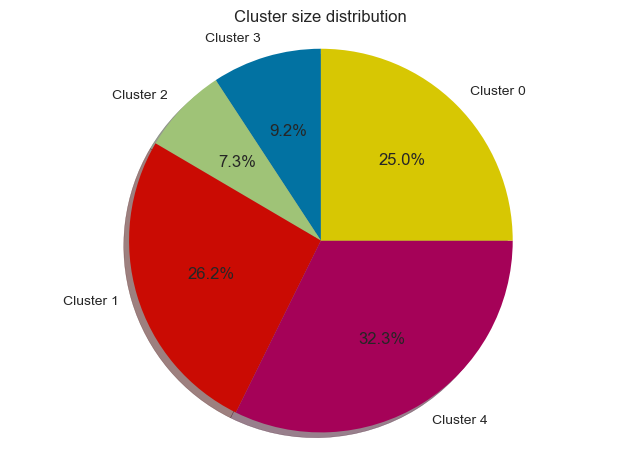

In [12]:
# Plot a pie chart showing the distribution of data samples for each cluster
from collections import Counter
counts = Counter(kmeans.labels_)
print(counts)
fig1, ax1 = plt.subplots()
ax1.pie(counts.values(), labels=[f'Cluster {i}' for i in counts.keys()], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal');  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Cluster size distribution');

**Note:** Clusters are somewhat balanced.

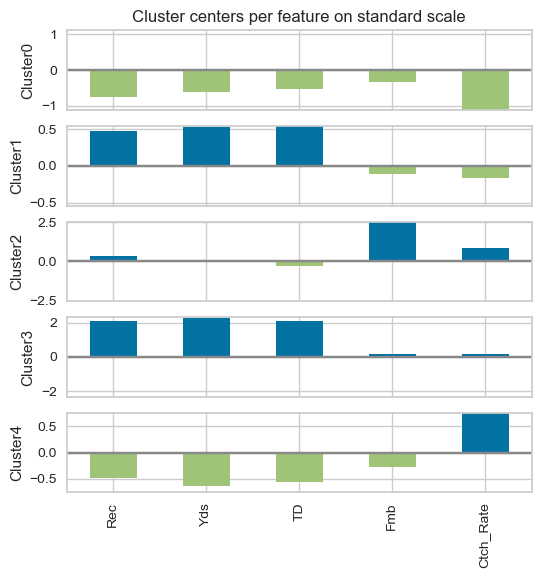

In [13]:
# Plot the cluster centers for each feature on the standard scale
f, axes = plt.subplots(kmeans.n_clusters, 1, figsize=(6, 6), sharex=True)

for i, ax in enumerate(axes):
    center = centers_scaled.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l>0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster{i}')
    ax.set_ylim(-maxPC, maxPC)
    if i == 0:
        ax.set_title('Cluster centers per feature on standard scale')


Based on the cluster distribution, was this the optimal number of clusters? Let's check the elbow method again using silhouette index and calinski-harabasz index.

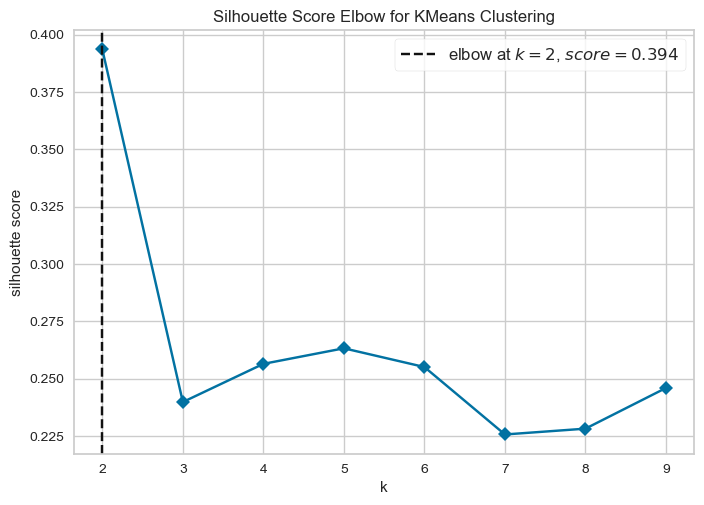

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=KMeans(n_clusters=9, random_state=54), k=(2, 10),
                 metric='silhouette', timings=False)

In [14]:
# Implement elbow method with silhouette index metric
kelbow_visualizer(KMeans(random_state=54), df_scaled, k=(2,10), 
                  metric='silhouette',
                 timings=False)

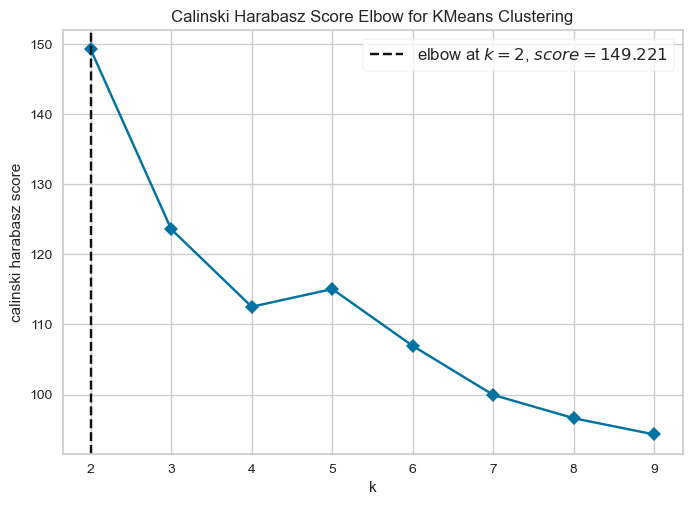

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>,
                 estimator=KMeans(n_clusters=9, random_state=54), k=(2, 10),
                 metric='calinski_harabasz', timings=False)

In [15]:
# Implement elbow method with calinski_harabasz index metric
kelbow_visualizer(KMeans(random_state=54), df_scaled, k=(2,10), 
                  metric='calinski_harabasz',
                 timings=False)